<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day2/Day2_Decomposition_ETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Decomposition 실습

Mauna Loa의 대기 중 CO2 농도 데이터(월별)을 이용해서 다양한 분해 방법을 비교해보겠습니다.
- Classical Decomposition (Additive/Multiplicative)
- STL (Seasonal and Trend decomposition using Loess)

## 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.datasets import get_rdataset
import warnings
warnings.filterwarnings('ignore')

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. 데이터 로드

In [2]:
# Mauna Loa 대기 중 CO2 농도 데이터 (1959-1997)
co2_data = pd.DataFrame(sm.datasets.co2.load().data)

In [3]:
co2_data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [4]:
# DatetimeIndex 설정
co2_data['date'] = pd.to_datetime(co2_data.index)
co2_data.set_index('date', inplace=True)

# 월별 평균으로 집계
co2_data = co2_data['co2'].resample('M').mean()

In [5]:
co2_data.describe()

,co2
count,521.000000
mean,339.822665
std,17.068711
min,313.400000
25%,324.125000
50%,337.950000
75%,354.675000
max,373.800000


In [6]:
co2_data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 526 entries, 1958-03-31 to 2001-12-31
Freq: ME
Series name: co2
Non-Null Count  Dtype  
--------------  -----  
521 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


In [7]:
missing_months = co2_data[co2_data.isna()]
print(missing_months)

date
1958-06-30   NaN
1958-10-31   NaN
1964-02-29   NaN
1964-03-31   NaN
1964-04-30   NaN
Name: co2, dtype: float64


In [8]:
# 결측치에 대해서 보간 진행
co2_data = co2_data.interpolate(method='time', limit_direction="both")

In [9]:
co2_data.isna().sum()

np.int64(0)

## 3. 데이터 시각화

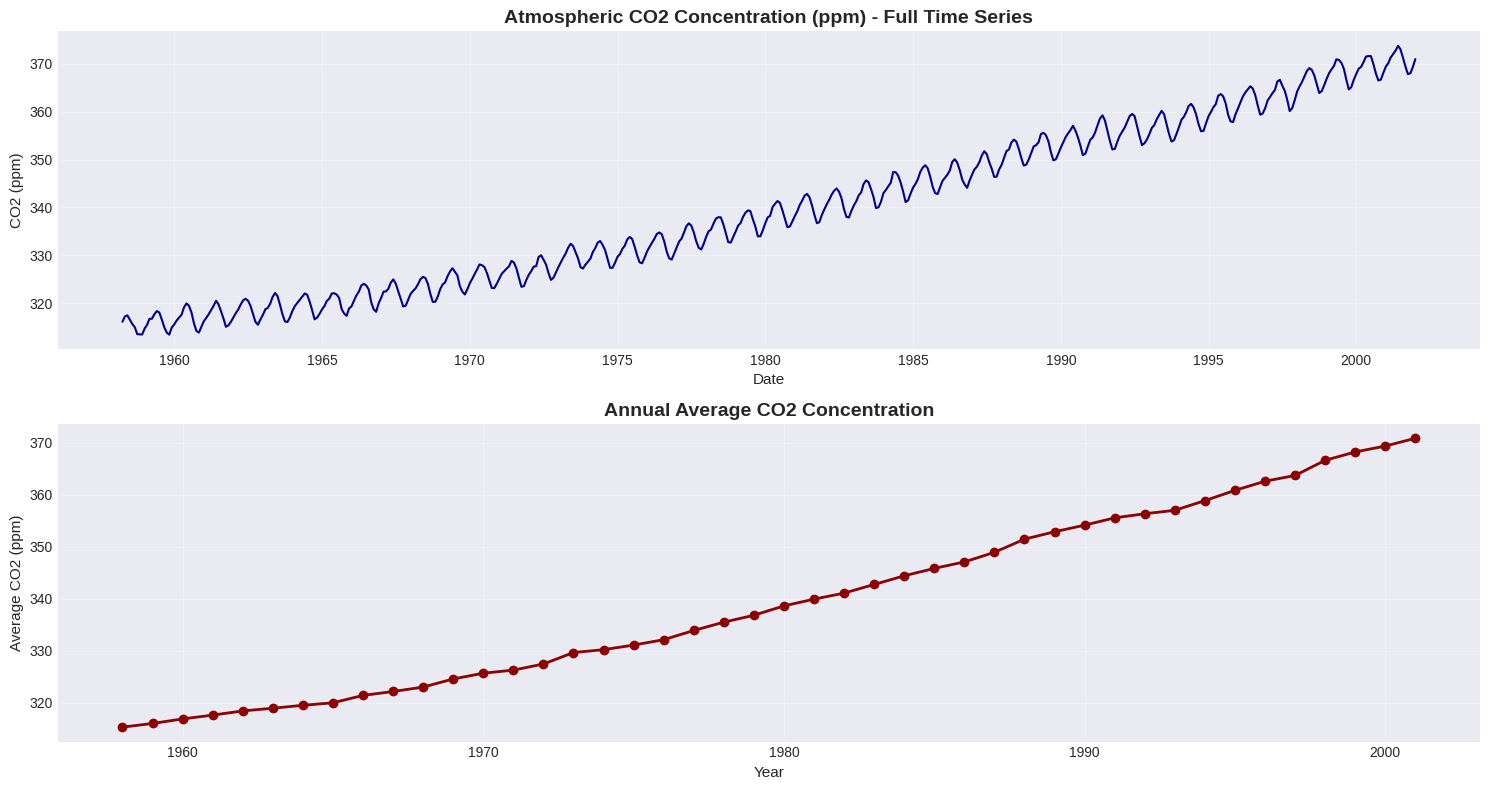

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# 전체 시계열
axes[0].plot(co2_data.index, co2_data.values, linewidth=1.5, color='darkblue')
axes[0].set_title('Atmospheric CO2 Concentration (ppm) - Full Time Series',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('CO2 (ppm)', fontsize=11)
axes[0].grid(True, alpha=0.3)

# 연도별 평균
yearly_mean = co2_data.groupby(co2_data.index.year).mean()
axes[1].plot(yearly_mean.index, yearly_mean.values, marker='o',
             linewidth=2, markersize=6, color='darkred')
axes[1].set_title('Annual Average CO2 Concentration', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Average CO2 (ppm)', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

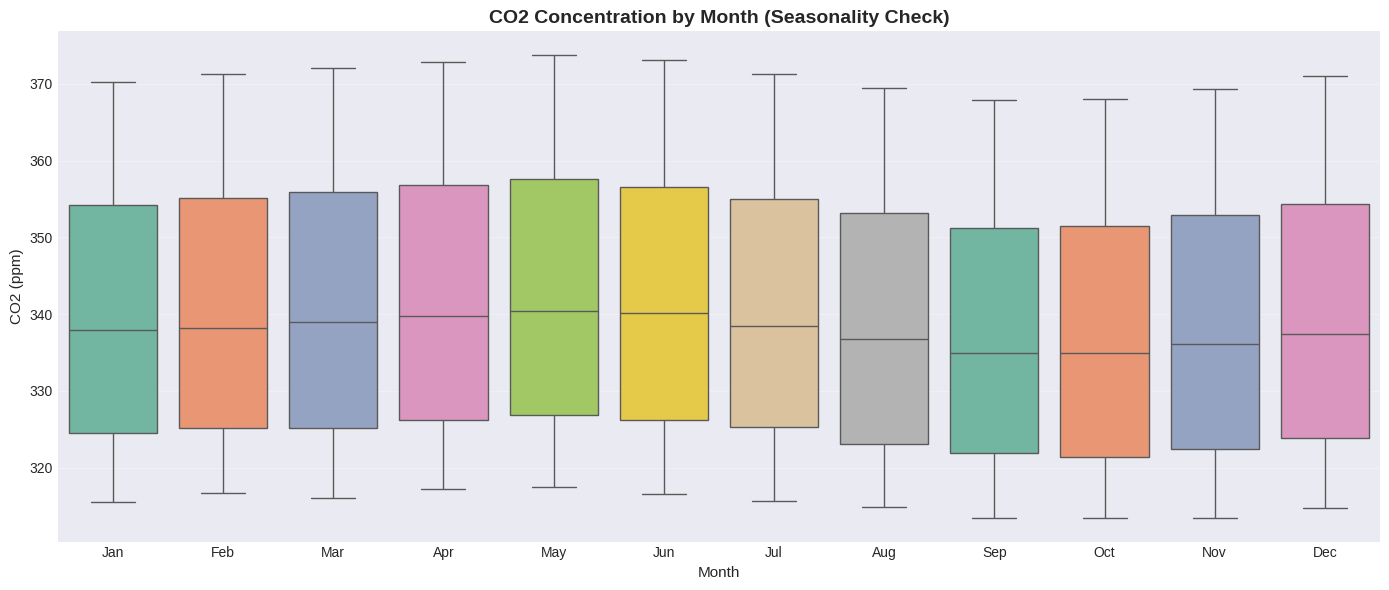

In [11]:
# 월별 박스플롯으로 계절성 확인
monthly_data = pd.DataFrame({
    'co2': co2_data.values,
    'month': co2_data.index.month
})

plt.figure(figsize=(14, 6))
sns.boxplot(data=monthly_data, x='month', y='co2', palette='Set2')
plt.title('CO2 Concentration by Month (Seasonality Check)', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=11)
plt.ylabel('CO2 (ppm)', fontsize=11)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 4. Classical Decomposition

Additive Model: Y = T + S + R


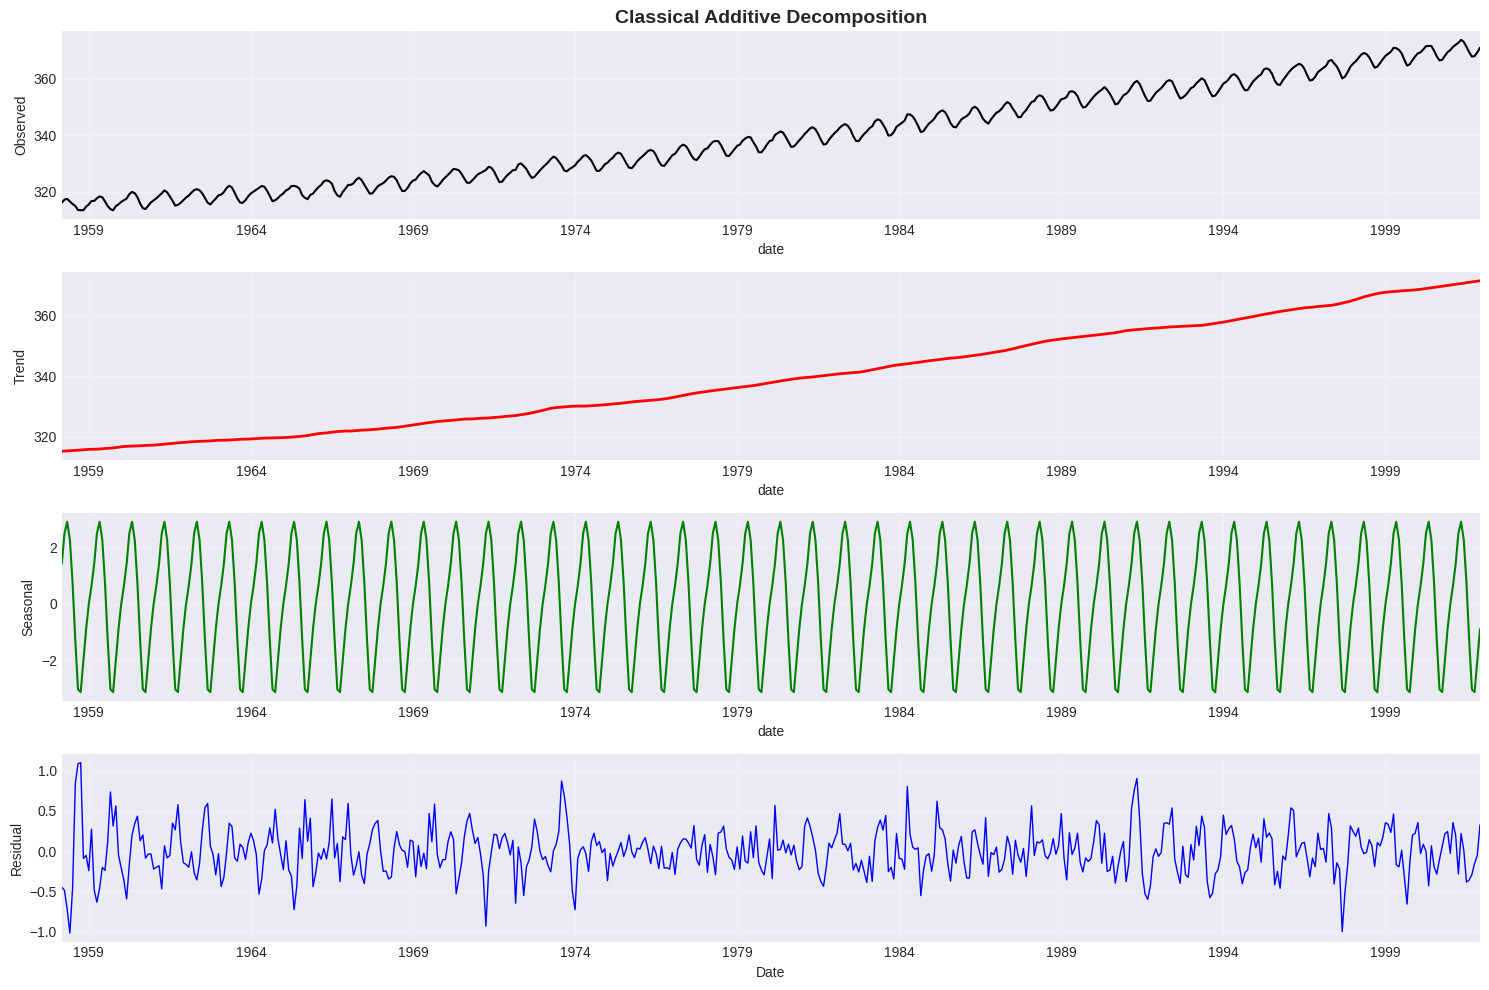

In [12]:
# 4.1 Additive Decomposition
print("Additive Model: Y = T + S + R")
decomp_add = seasonal_decompose(co2_data, model='additive', period=12, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

decomp_add.observed.plot(ax=axes[0], color='black', linewidth=1.5)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title('Classical Additive Decomposition', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomp_add.trend.plot(ax=axes[1], color='red', linewidth=2)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

decomp_add.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

decomp_add.resid.plot(ax=axes[3], color='blue', linewidth=1)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Multiplicative Model: Y = T × S × R


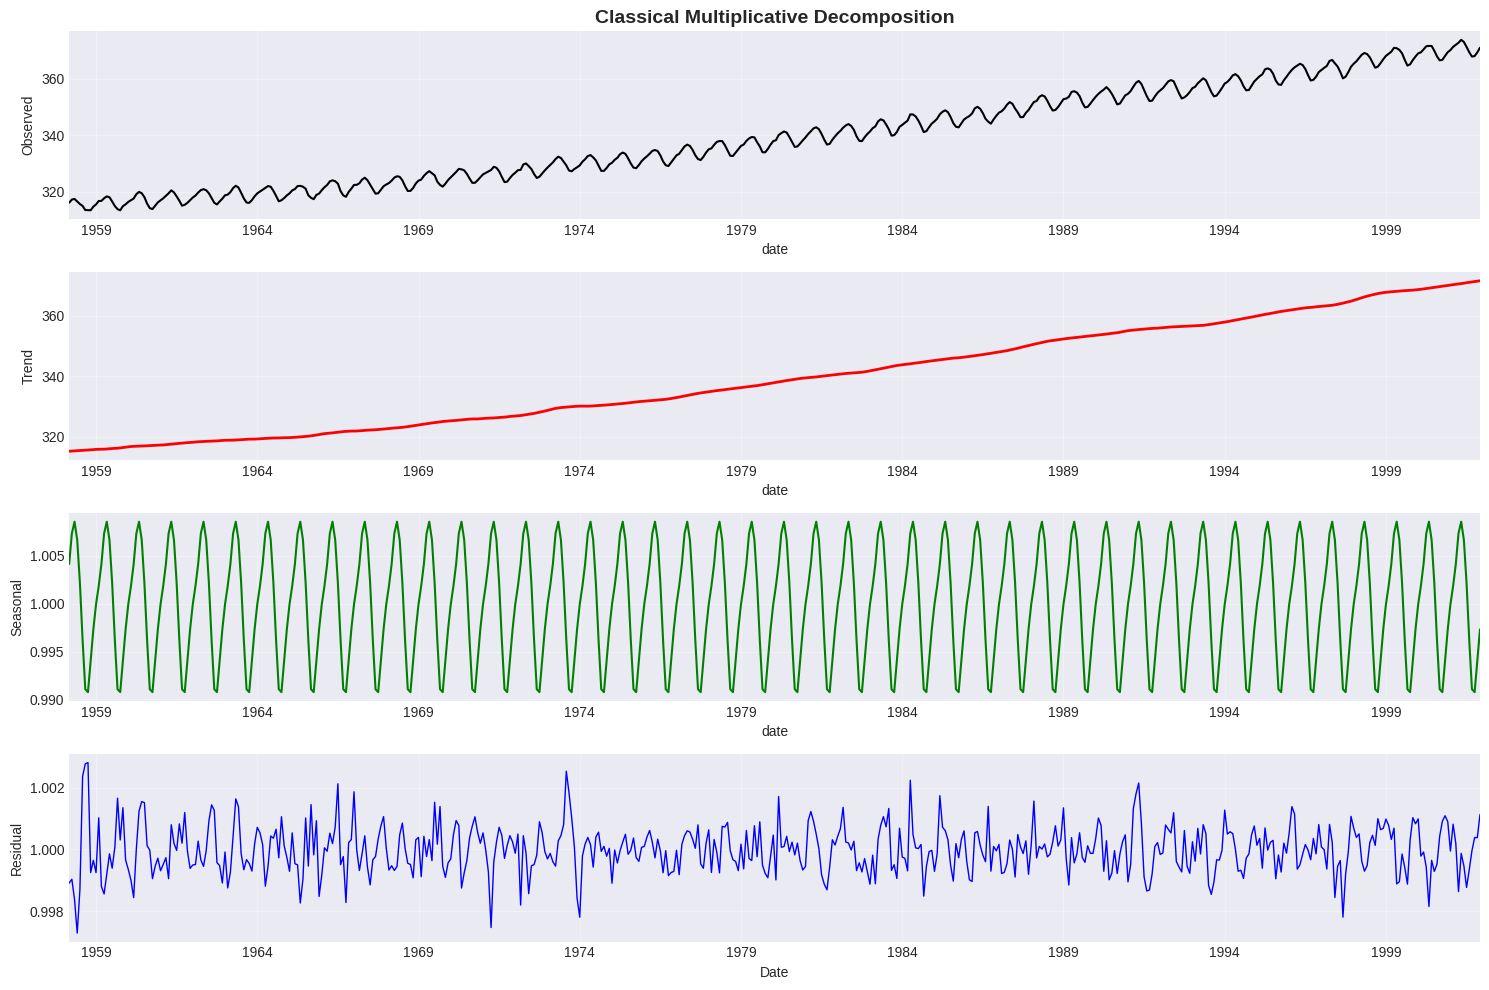

In [13]:
# 4.2 Multiplicative Decomposition
print("\nMultiplicative Model: Y = T × S × R")
decomp_mul = seasonal_decompose(co2_data, model='multiplicative', period=12, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

decomp_mul.observed.plot(ax=axes[0], color='black', linewidth=1.5)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title('Classical Multiplicative Decomposition', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomp_mul.trend.plot(ax=axes[1], color='red', linewidth=2)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

decomp_mul.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

decomp_mul.resid.plot(ax=axes[3], color='blue', linewidth=1)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

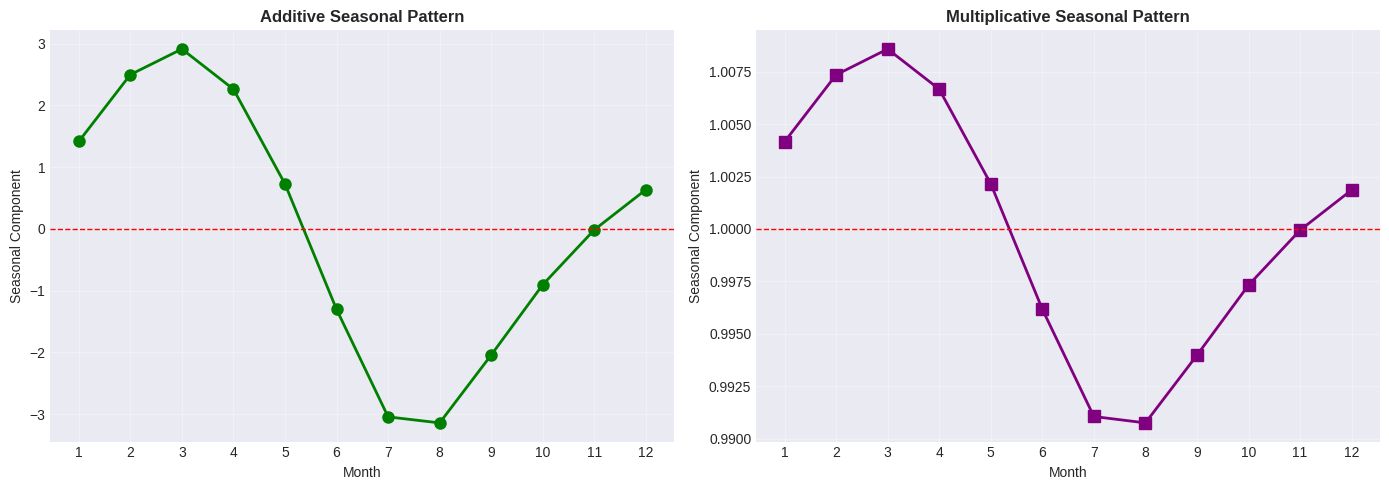

In [14]:
# 계절 패턴 추출 및 시각화
seasonal_pattern_add = decomp_add.seasonal[:12]
seasonal_pattern_mul = decomp_mul.seasonal[:12]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, 13), seasonal_pattern_add.values, marker='o',
             linewidth=2, markersize=8, color='green')
axes[0].set_title('Additive Seasonal Pattern', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=10)
axes[0].set_ylabel('Seasonal Component', fontsize=10)
axes[0].set_xticks(range(1, 13))
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)

axes[1].plot(range(1, 13), seasonal_pattern_mul.values, marker='s',
             linewidth=2, markersize=8, color='purple')
axes[1].set_title('Multiplicative Seasonal Pattern', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=10)
axes[1].set_ylabel('Seasonal Component', fontsize=10)
axes[1].set_xticks(range(1, 13))
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

## STL Decomposition

STL 특징
- Robust to outliers
- Handles any type of seasonality
- Seasonal component can vary over time
- More flexible than classical decomposition

LOESS는 대칭적인 구간(윈도우) 안에서 중심점을 기준으로 양쪽의 데이터를 균등하게 사용하는 방식이기 때문에 `seasonal` 파라미터는 홀수로 설정. 이는, 한 주기의 계절성을 얼마나 “짧은 국소 범위로” 또는 “넓은 범위로” 추정할지 조절하는 매개변수.
- 작은 seasonal 값 → 좁은 윈도우 → 더 민감하고 빠르게 변함 (유연함)
- 큰 seasonal 값 → 넓은 윈도우 → 느리고 매끄럽게 변함 (부드러움)

In [15]:
# STL with default parameters
stl_default = STL(co2_data, seasonal=13, trend=None, robust=False)
result_default = stl_default.fit()

# STL with robust option (이상치에 강건)
stl_robust = STL(co2_data, seasonal=13, trend=None, robust=True)
result_robust = stl_robust.fit()

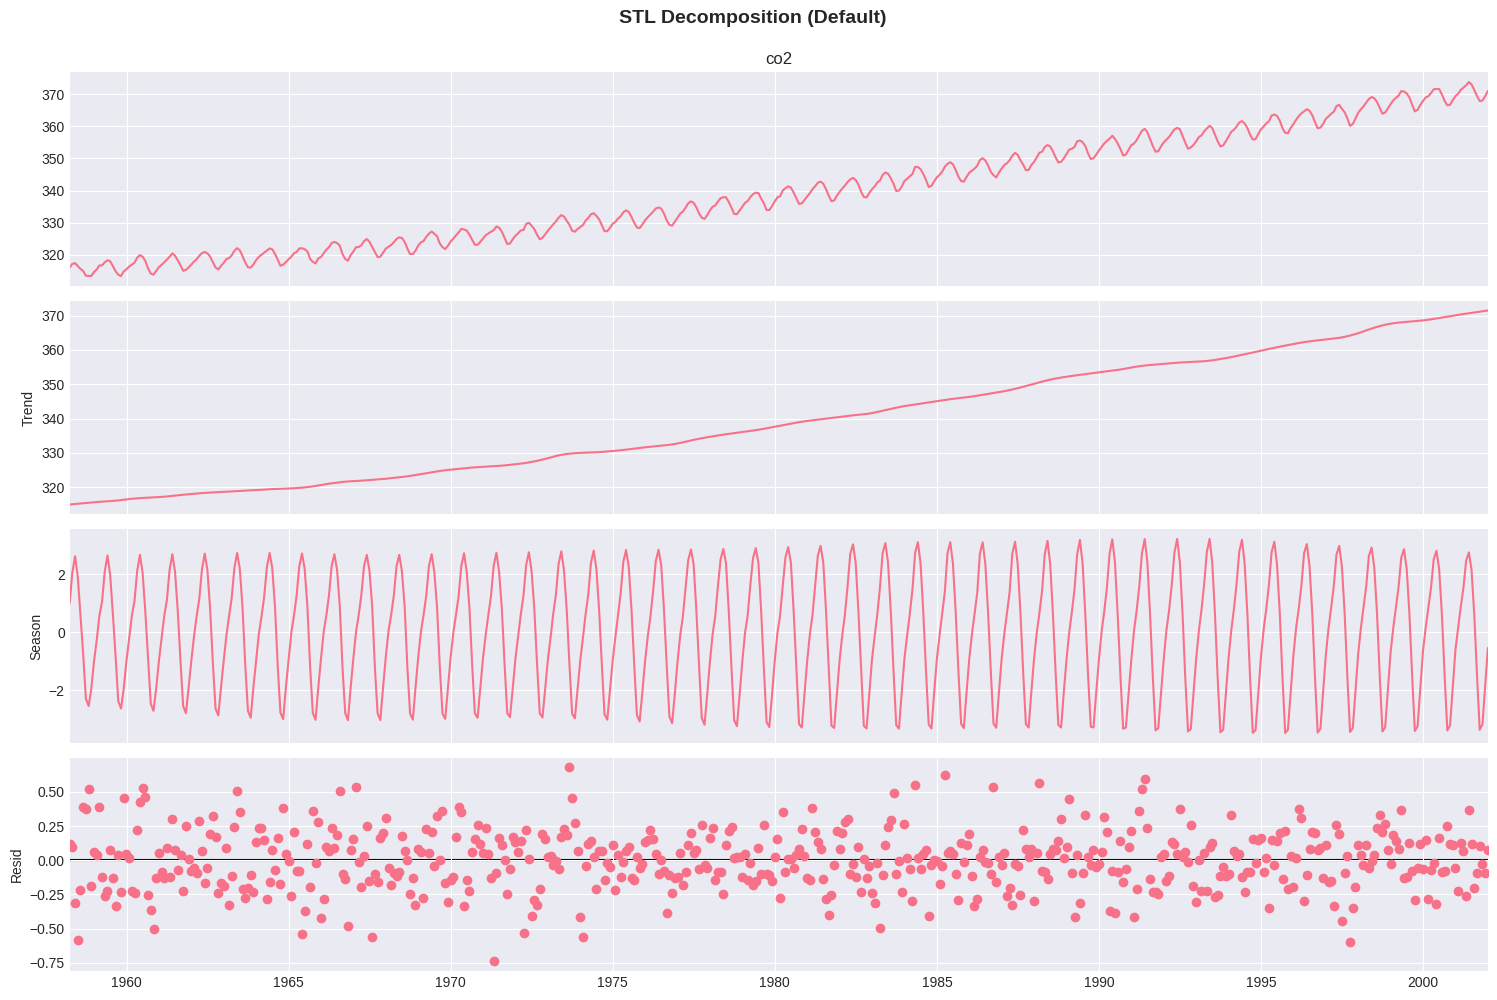

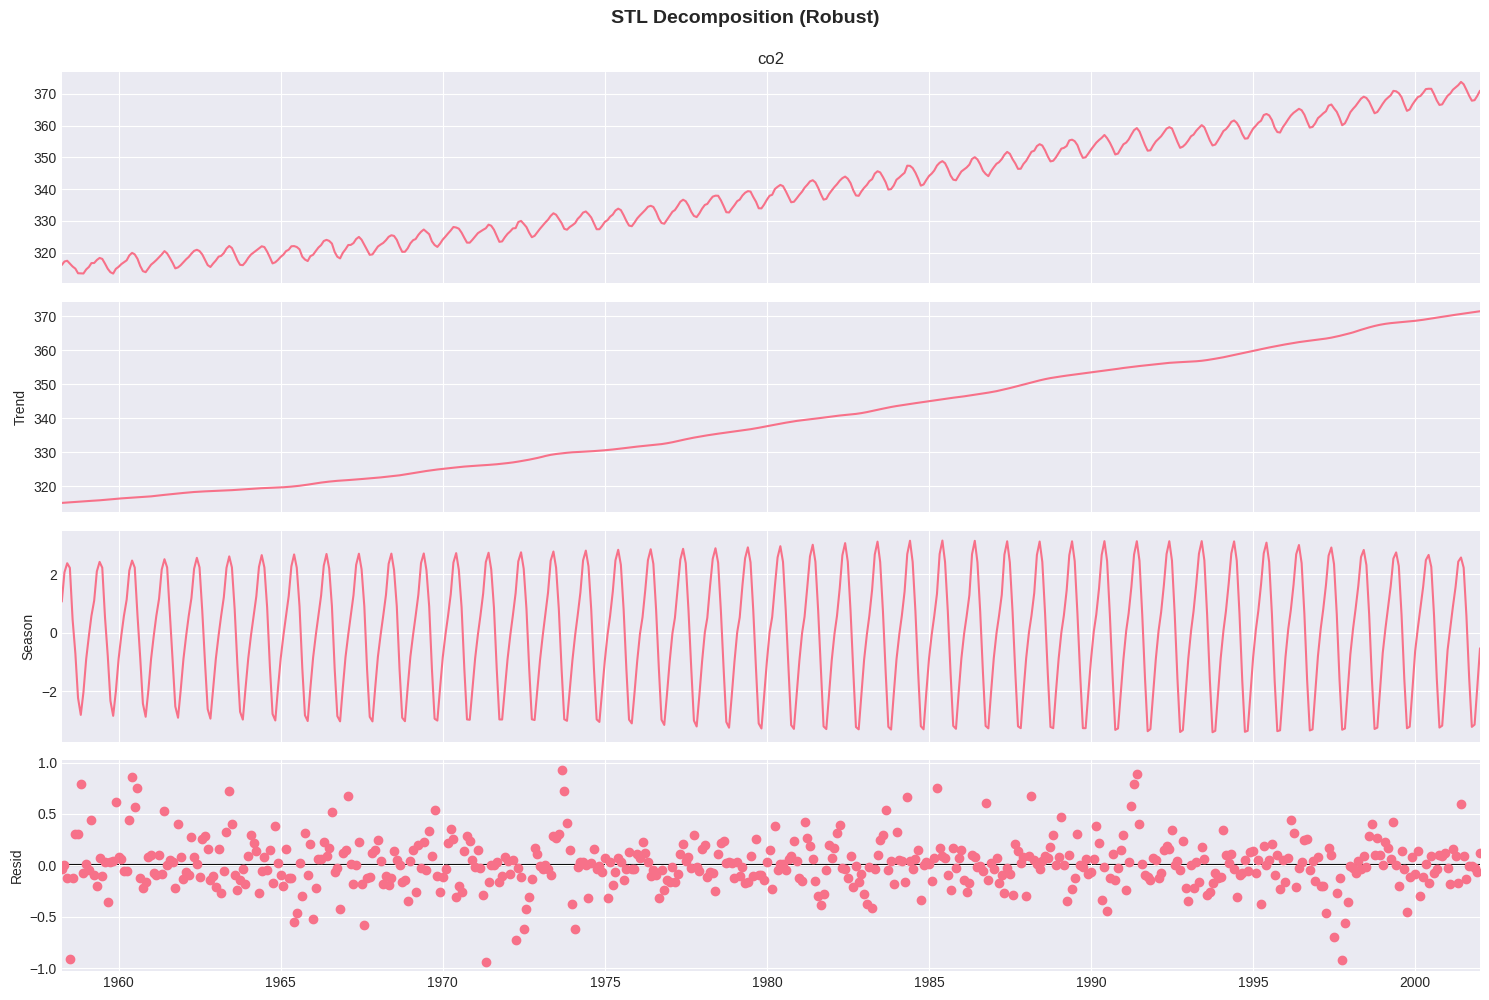

In [16]:
# STL 결과 시각화
fig = result_default.plot()
fig.suptitle('STL Decomposition (Default)', fontsize=14, fontweight='bold', y=0.995)
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.show()

fig = result_robust.plot()
fig.suptitle('STL Decomposition (Robust)', fontsize=14, fontweight='bold', y=0.995)
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.show()

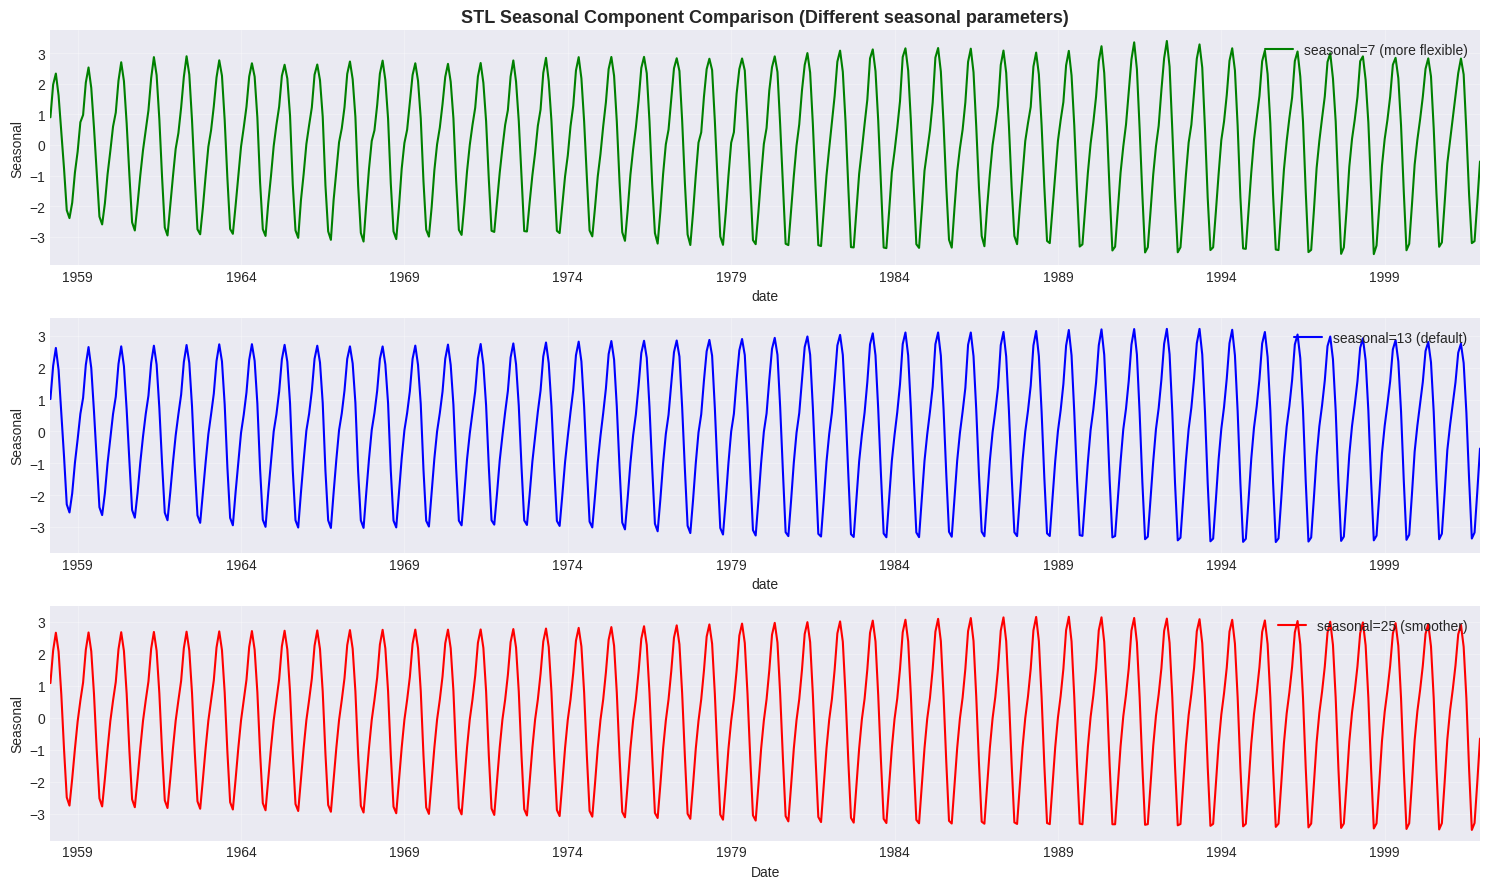

In [17]:
# STL 파라미터 변경 효과 비교
stl_seasonal_7 = STL(co2_data, seasonal=7).fit()
stl_seasonal_13 = STL(co2_data, seasonal=13).fit()
stl_seasonal_25 = STL(co2_data, seasonal=25).fit()

fig, axes = plt.subplots(3, 1, figsize=(15, 9))

stl_seasonal_7.seasonal.plot(ax=axes[0], color='green', linewidth=1.5)
axes[0].set_ylabel('Seasonal', fontsize=10)
axes[0].set_title('STL Seasonal Component Comparison (Different seasonal parameters)',
                  fontsize=13, fontweight='bold')
axes[0].legend(['seasonal=7 (more flexible)'], loc='upper right')
axes[0].grid(True, alpha=0.3)

stl_seasonal_13.seasonal.plot(ax=axes[1], color='blue', linewidth=1.5)
axes[1].set_ylabel('Seasonal', fontsize=10)
axes[1].legend(['seasonal=13 (default)'], loc='upper right')
axes[1].grid(True, alpha=0.3)

stl_seasonal_25.seasonal.plot(ax=axes[2], color='red', linewidth=1.5)
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].set_xlabel('Date', fontsize=10)
axes[2].legend(['seasonal=25 (smoother)'], loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 분해 방법 비교

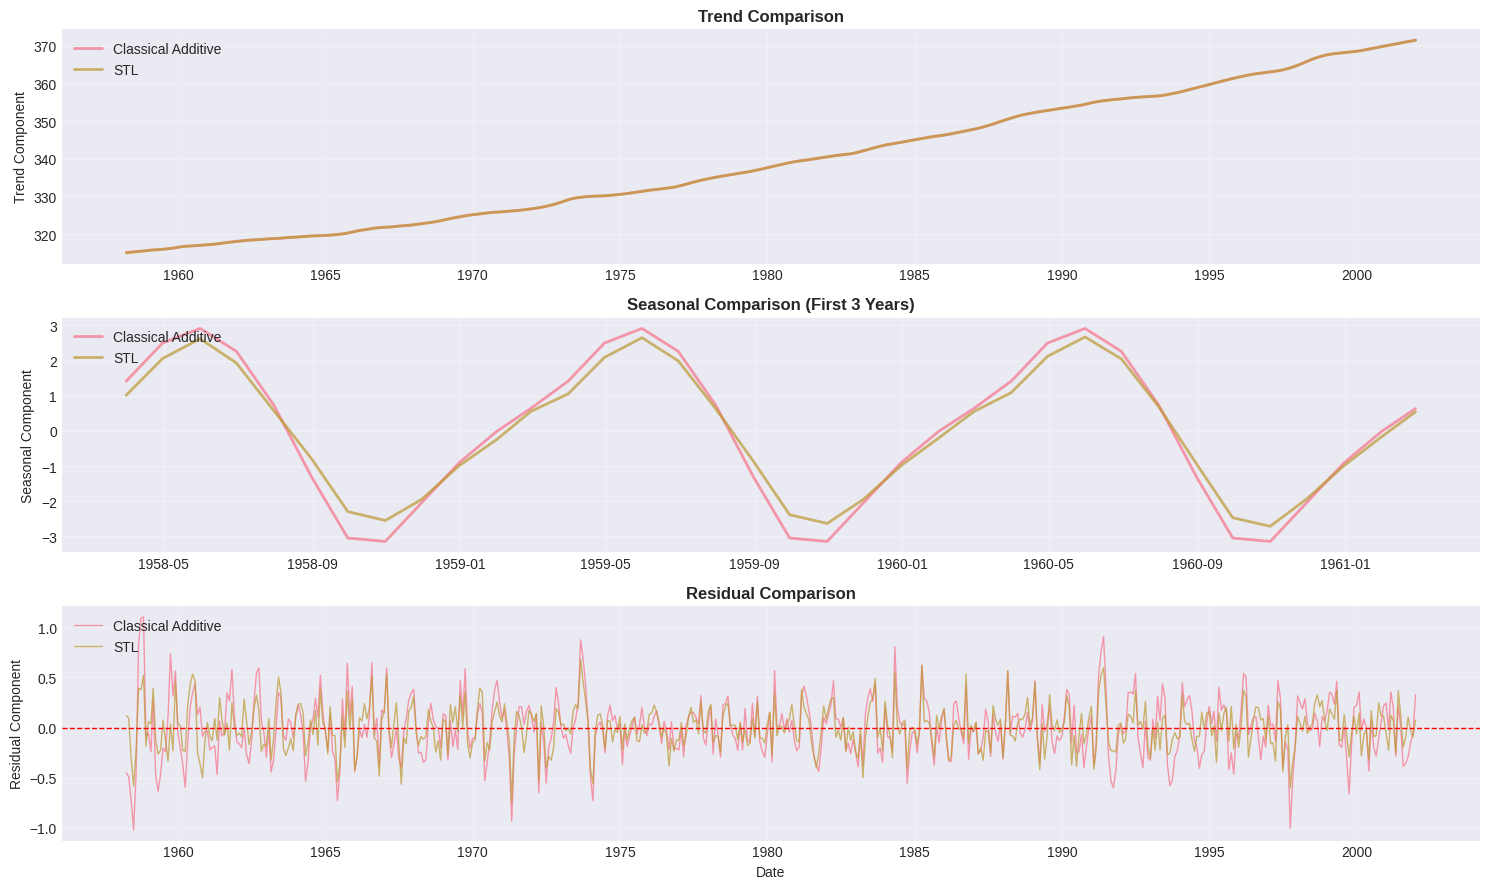

In [18]:
# Classical vs STL 추세 비교
fig, axes = plt.subplots(3, 1, figsize=(15, 9))

# Trend 비교
axes[0].plot(decomp_add.trend.index, decomp_add.trend.values,
             label='Classical Additive', linewidth=2, alpha=0.7)
axes[0].plot(result_default.trend.index, result_default.trend.values,
             label='STL', linewidth=2, alpha=0.7)
axes[0].set_ylabel('Trend Component', fontsize=10)
axes[0].set_title('Trend Comparison', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Seasonal 비교 (첫 3년)
axes[1].plot(decomp_add.seasonal[:36].index, decomp_add.seasonal[:36].values,
             label='Classical Additive', linewidth=2, alpha=0.7)
axes[1].plot(result_default.seasonal[:36].index, result_default.seasonal[:36].values,
             label='STL', linewidth=2, alpha=0.7)
axes[1].set_ylabel('Seasonal Component', fontsize=10)
axes[1].set_title('Seasonal Comparison (First 3 Years)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# Residual 비교
axes[2].plot(decomp_add.resid.index, decomp_add.resid.values,
             label='Classical Additive', linewidth=1, alpha=0.7)
axes[2].plot(result_default.resid.index, result_default.resid.values,
             label='STL', linewidth=1, alpha=0.7)
axes[2].set_ylabel('Residual Component', fontsize=10)
axes[2].set_xlabel('Date', fontsize=10)
axes[2].set_title('Residual Comparison', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

## 7. 잔차 분석

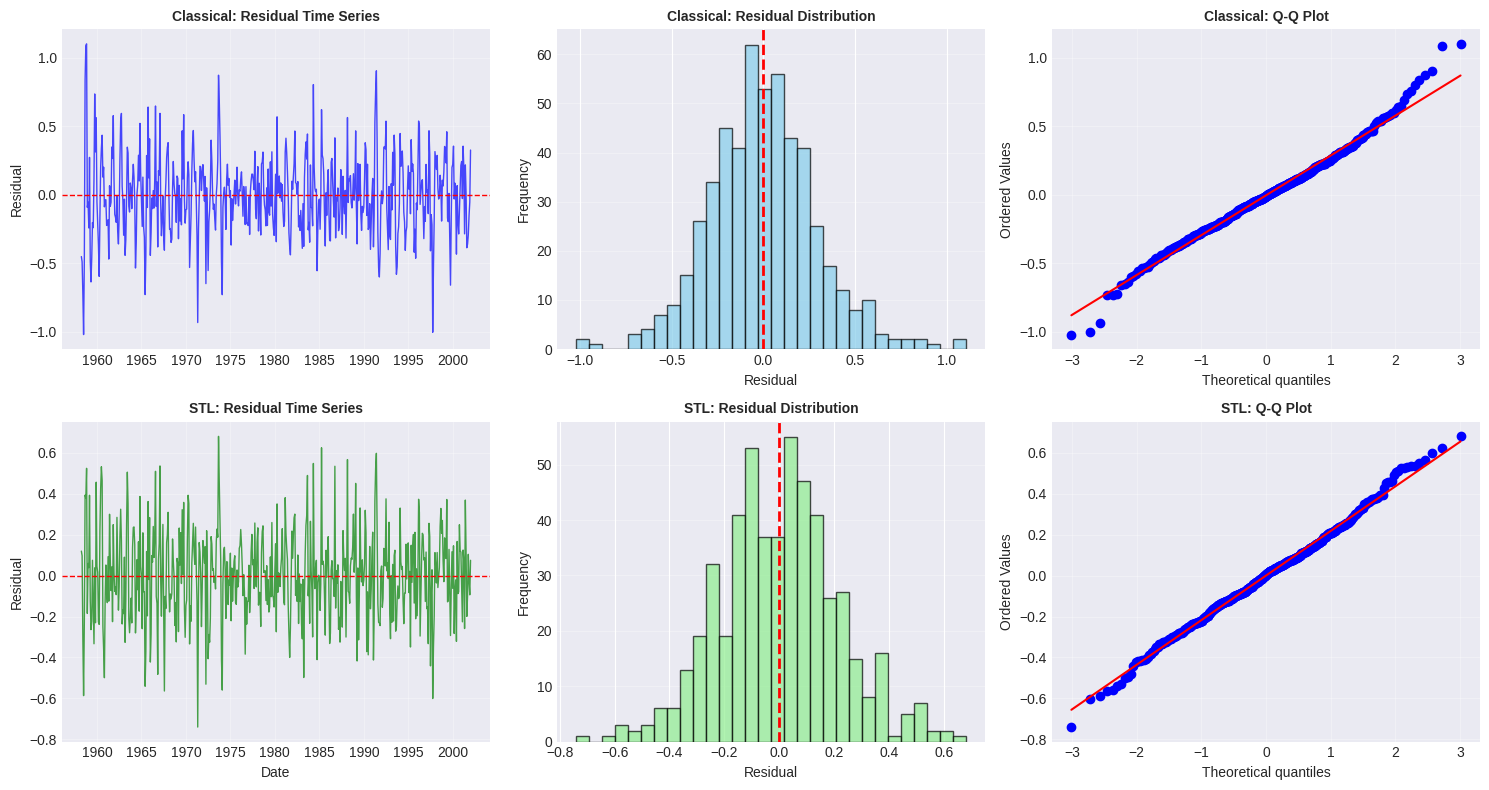

In [19]:
residuals_classical = decomp_add.resid.dropna()
residuals_stl = result_default.resid

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Classical Additive 잔차
axes[0, 0].plot(residuals_classical.index, residuals_classical.values,
                linewidth=1, color='blue', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Classical: Residual Time Series', fontweight='bold', fontsize=10)
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals_classical, bins=30, edgecolor='black',
                alpha=0.7, color='skyblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Classical: Residual Distribution', fontweight='bold', fontsize=10)
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3, axis='y')

stats.probplot(residuals_classical, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Classical: Q-Q Plot', fontweight='bold', fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# STL 잔차
axes[1, 0].plot(residuals_stl.index, residuals_stl.values,
                linewidth=1, color='green', alpha=0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 0].set_title('STL: Residual Time Series', fontweight='bold', fontsize=10)
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(residuals_stl.dropna(), bins=30, edgecolor='black',
                alpha=0.7, color='lightgreen')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('STL: Residual Distribution', fontweight='bold', fontsize=10)
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

stats.probplot(residuals_stl.dropna(), dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('STL: Q-Q Plot', fontweight='bold', fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# 잔차 통계량
print("Classical Additive Residual Statistics:")
print(f"  Mean: {residuals_classical.mean():.6f}")
print(f"  Std Dev: {residuals_classical.std():.6f}")
print(f"  Skewness: {residuals_classical.skew():.6f}")
print(f"  Kurtosis: {residuals_classical.kurtosis():.6f}")

print("\nSTL Residual Statistics:")
print(f"  Mean: {residuals_stl.mean():.6f}")
print(f"  Std Dev: {residuals_stl.std():.6f}")
print(f"  Skewness: {residuals_stl.skew():.6f}")
print(f"  Kurtosis: {residuals_stl.kurtosis():.6f}")

Classical Additive Residual Statistics:
  Mean: -0.003830
  Std Dev: 0.291573
  Skewness: 0.193993
  Kurtosis: 1.129087

STL Residual Statistics:
  Mean: -0.000489
  Std Dev: 0.217291
  Skewness: 0.074940
  Kurtosis: 0.377665


# ETS 실습: UNCTAD 연간 상품무역 총액 데이터 활용

이 데이터셋 “Merchandise: Total trade and share, annual” 은 UNCTADstat에서 제공하는 연간 전 세계 상품무역 총액(수출과 수입의 합계) 자료입니다. 모든 값은 미국 달러 백만 단위(USD million) 로 표시되어 있으며, 각 연도별로 국가 간 상품 교역 규모의 변화를 비교할 수 있습니다. 이번 실습에서는 이 데이터를 활용하여 지수 평활(ETS, Exponential Smoothing) 모델을 적용하고, 국제 무역의 장기 추세와 변화를 분석 및 예측하는 것을 목표로 합니다.

데이터 링크: https://unctadstat.unctad.org/datacentre/dataviewer/US.TradeMerchTotal

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [22]:
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"

# 데이터 로드
merchandise_export_url = urljoin(data_repo_url, "world_merchandise_export.csv")
df = pd.read_csv(merchandise_export_url)

In [23]:
df.head()

,Year,World,Africa,Americas,Asia,Europe,Oceania,Asia and Oceania,Northern America and Europe,"Europe, Northern America, Australia and New Zealand",...,LLDCs (Landlocked developing countries),SIDS (Small island developing States) (UN-OHRLLS),SIDS: Atlantic and Indian Ocean,SIDS: Caribbean,SIDS: Pacific,BRICS,European Union (2020 …),G20 (Group of Twenty),G-77 (Group of 77),OECD (Organisation for Economic Cooperation and Development)
0,1948,58662.0,4374.0,23082.0,7291.0,21674.0,2241.0,9532.0,37535.0,39702.0,...,532.0,2322.0,71.0,1486.0,764.0,6940.0,12261.0,36091.0,16999.0,39591.0
1,1949,58654.0,4295.0,21318.0,7206.0,23637.0,2198.0,9404.0,38744.0,40871.0,...,519.0,2135.0,67.0,1386.0,683.0,6528.0,13990.0,35526.0,15467.0,41178.0
2,1950,61862.0,4452.0,20230.0,10237.0,24689.0,2254.0,12491.0,37710.0,39893.0,...,615.0,2743.0,60.0,1606.0,1078.0,8007.0,15171.0,35305.0,18908.0,40376.0
3,1951,82876.0,5554.0,26566.0,14060.0,33875.0,2821.0,16881.0,51765.0,54497.0,...,825.0,3737.0,79.0,1994.0,1664.0,10279.0,22177.0,46556.0,24288.0,55323.0
4,1952,79801.0,5491.0,25922.0,11528.0,34352.0,2509.0,14037.0,52198.0,54601.0,...,864.0,3224.0,86.0,1949.0,1189.0,9172.0,22145.0,44785.0,21309.0,54965.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 37 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Year                                                          77 non-null     int64  
 1   World                                                         77 non-null     float64
 2   Africa                                                        77 non-null     float64
 3   Americas                                                      77 non-null     float64
 4   Asia                                                          77 non-null     float64
 5   Europe                                                        77 non-null     float64
 6   Oceania                                                       77 non-null     float64
 7   Asia and Oceania                                              77 non-null

In [25]:
df.describe()

,Year,World,Africa,Americas,Asia,Europe,Oceania,Asia and Oceania,Northern America and Europe,"Europe, Northern America, Australia and New Zealand",...,LLDCs (Landlocked developing countries),SIDS (Small island developing States) (UN-OHRLLS),SIDS: Atlantic and Indian Ocean,SIDS: Caribbean,SIDS: Pacific,BRICS,European Union (2020 …),G20 (Group of Twenty),G-77 (Group of 77),OECD (Organisation for Economic Cooperation and Development)
count,77.000000,7.700000e+01,77.000000,7.700000e+01,7.700000e+01,7.700000e+01,77.000000,7.700000e+01,7.700000e+01,7.700000e+01,...,77.000000,77.000000,77.000000,77.000000,77.000000,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01
mean,1986.000000,6.152186e+06,174809.337662,1.077653e+06,2.293969e+06,2.509203e+06,96551.805195,2.390521e+06,3.245853e+06,3.337869e+06,...,56572.740260,147672.857143,1430.441558,16860.558442,129381.792208,1.141089e+06,1.988926e+06,3.664408e+06,1.850157e+06,3.818667e+06
std,22.371857,7.547057e+06,208859.582317,1.236366e+06,3.147436e+06,2.860008e+06,125816.878624,3.272663e+06,3.663921e+06,3.782099e+06,...,84344.406267,181339.669279,1395.799521,13729.002778,167505.193419,1.730979e+06,2.280652e+06,4.490777e+06,2.656043e+06,4.337145e+06
min,1948.000000,5.865400e+04,4295.000000,2.023000e+04,7.206000e+03,2.167400e+04,2198.000000,9.404000e+03,3.753500e+04,3.970200e+04,...,519.000000,2135.000000,60.000000,1386.000000,683.000000,6.528000e+03,1.226100e+04,3.530500e+04,1.546700e+04,3.959100e+04
25%,1967.000000,2.188780e+05,11555.000000,5.549500e+04,3.161300e+04,1.154560e+05,4758.000000,3.637100e+04,1.574300e+05,1.619010e+05,...,1861.000000,4122.000000,114.000000,2586.000000,1627.000000,2.174100e+04,8.492900e+04,1.149350e+05,4.086900e+04,1.626520e+05
50%,1986.000000,2.141453e+06,87324.000000,4.329640e+05,5.385690e+05,1.112267e+06,30643.000000,5.677560e+05,1.430096e+06,1.458545e+06,...,8386.000000,46769.000000,828.000000,14947.000000,26083.000000,2.295370e+05,8.420400e+05,1.164244e+06,4.327140e+05,1.619030e+06
75%,2005.000000,1.051204e+07,301599.000000,1.848376e+06,3.591672e+06,4.635860e+06,134537.000000,3.726209e+06,5.897876e+06,6.025703e+06,...,78160.000000,267691.000000,2711.000000,26187.000000,236367.000000,1.549872e+06,3.689908e+06,6.310232e+06,2.739163e+06,6.947741e+06
max,2024.000000,2.490322e+07,662323.000000,4.094129e+06,1.057906e+07,9.100470e+06,477295.000000,1.105635e+07,1.176901e+07,1.222679e+07,...,281398.000000,588844.000000,4246.000000,50047.000000,535683.000000,6.007663e+06,7.211334e+06,1.468311e+07,9.128926e+06,1.382471e+07


## 2. 데이터 전처리 및 EDA

In [26]:
# 세계 전체 수출 데이터 추출
data = df[['Year', 'World']].copy()
data = data.dropna()
data = data.sort_values('Year')

In [27]:
print("\n결측치 확인:")
print(data.isnull().sum())


결측치 확인:
Year     0
World    0
dtype: int64


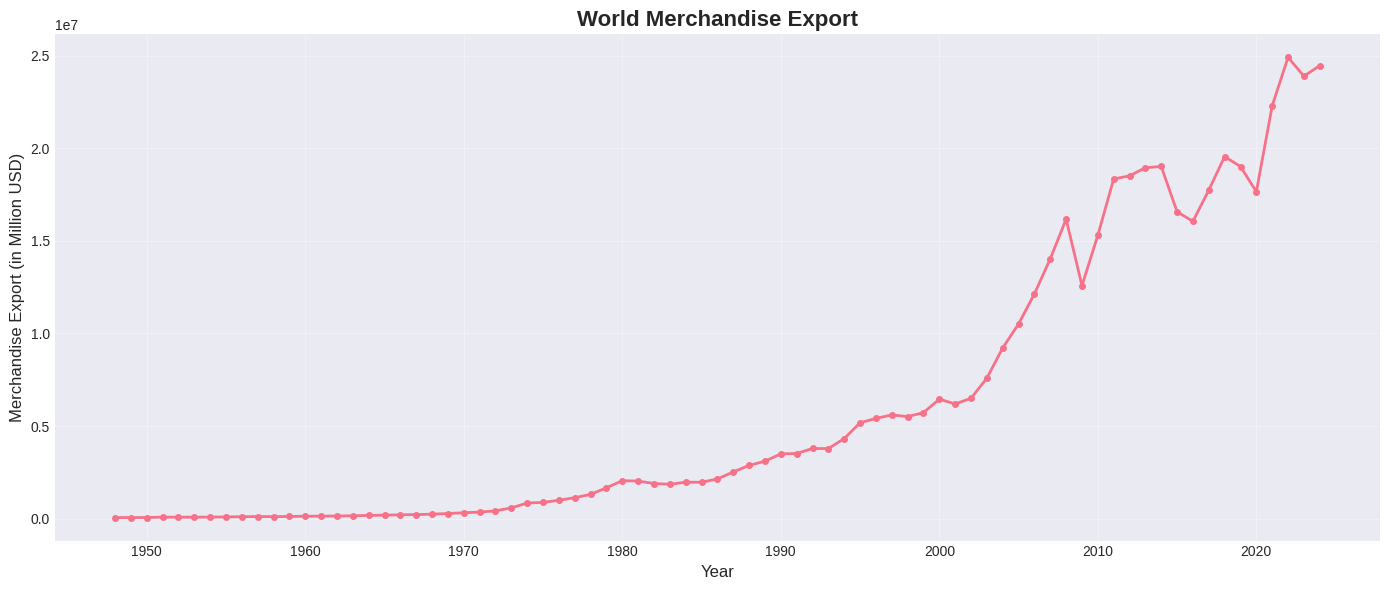

In [28]:
# 시각화
plt.figure(figsize=(14, 6))
plt.plot(data['Year'], data['World'], marker='o', linewidth=2, markersize=4)
plt.title('World Merchandise Export', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Merchandise Export (in Million USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. 시계열 분해 (Decomposition)

In [29]:
# 시계열을 인덱스로 설정
ts_data = data.set_index('Year')['World']

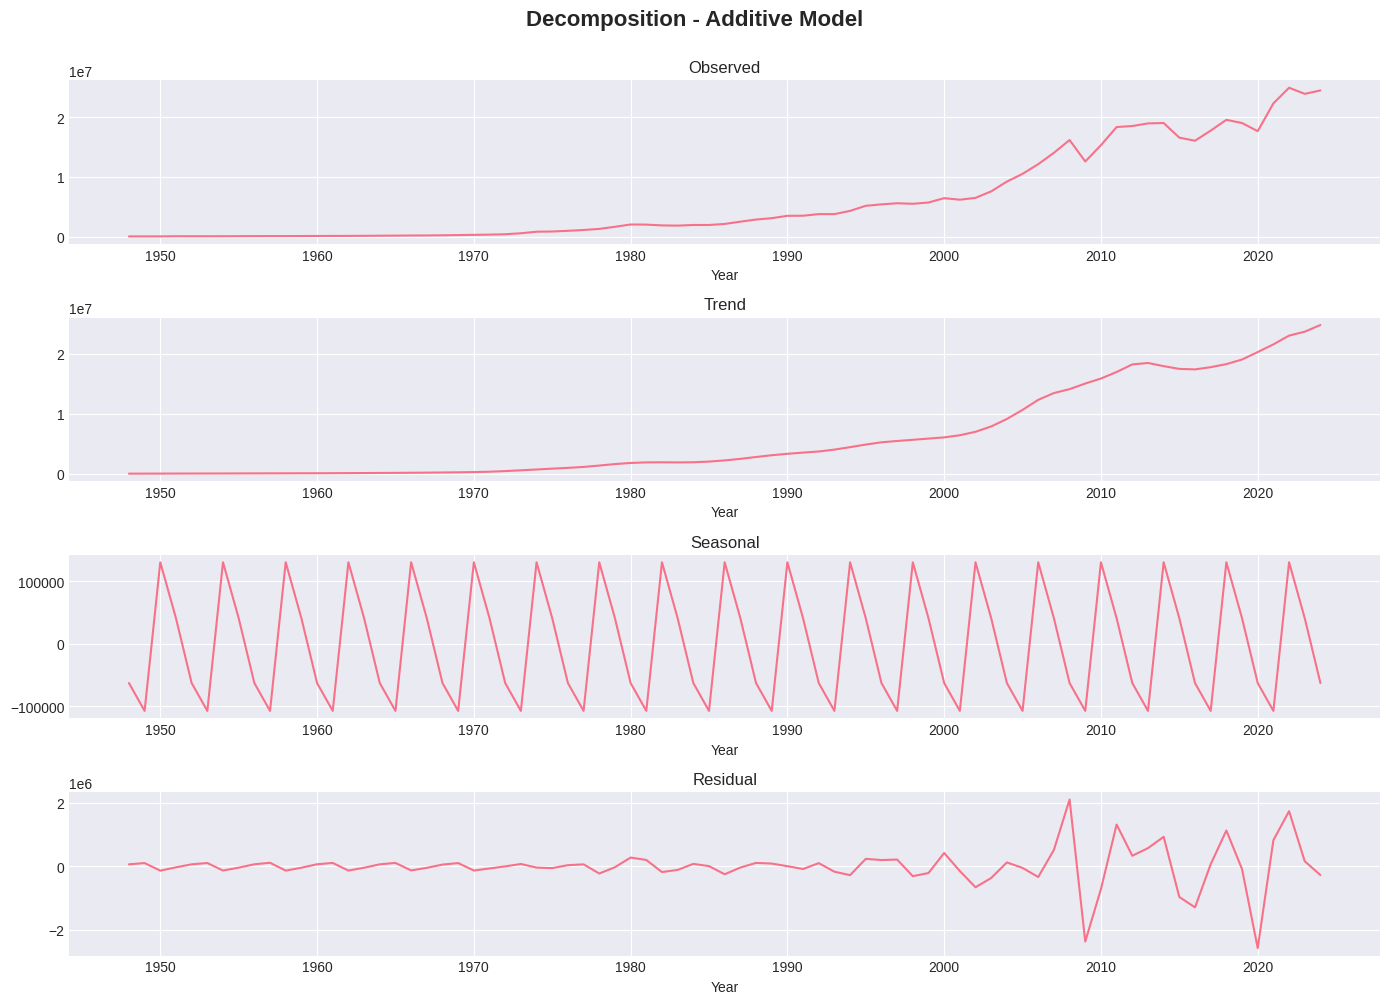

In [30]:
# 시계열 분해 (가법 모형)
# 4년 주기 가정
decomposition_add = seasonal_decompose(ts_data, model='additive', period=4, extrapolate_trend='freq')

# 가법 모형 시각화
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomposition_add.observed.plot(ax=axes[0], title='Observed')
decomposition_add.trend.plot(ax=axes[1], title='Trend')
decomposition_add.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition_add.resid.plot(ax=axes[3], title='Residual')
plt.suptitle('Decomposition - Additive Model', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

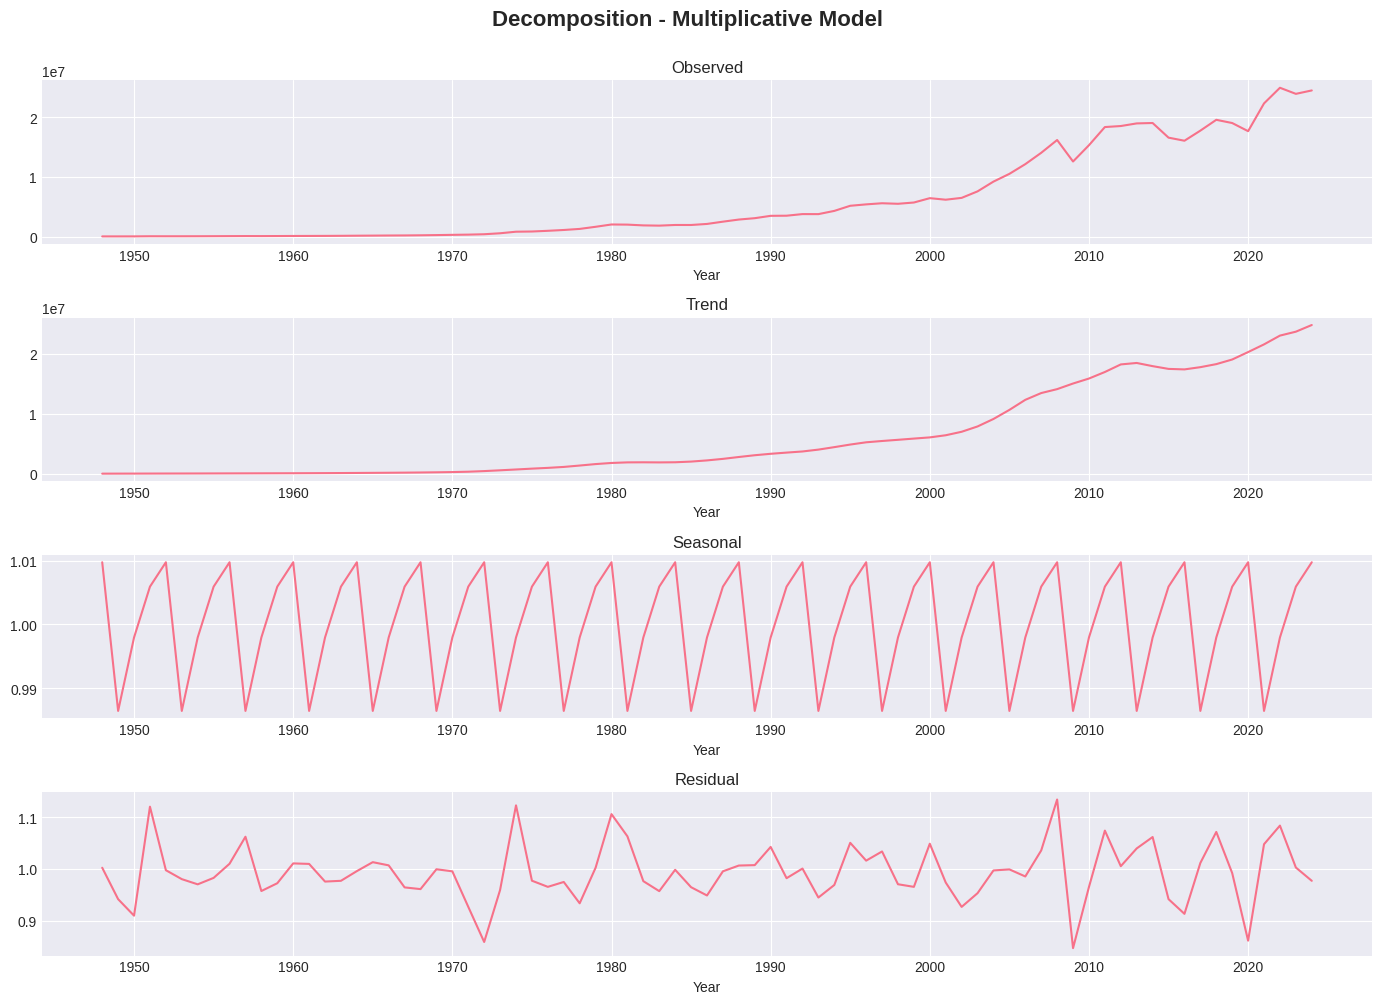

In [31]:
# 시계열 분해 (승법 모형)
decomposition_mul = seasonal_decompose(ts_data, model='multiplicative', period=4, extrapolate_trend='freq')

# 승법 모형 시각화
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomposition_mul.observed.plot(ax=axes[0], title='Observed')
decomposition_mul.trend.plot(ax=axes[1], title='Trend')
decomposition_mul.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition_mul.resid.plot(ax=axes[3], title='Residual')
plt.suptitle('Decomposition - Multiplicative Model', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 4. Train/Test 데이터 분할

전체 데이터의 75%를 훈련 데이터로, 25%를 테스트 데이터로 분할

In [32]:
train_size = int(len(ts_data) * 0.75)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print(f"\n훈련 데이터 크기: {len(train_data)}")
print(f"테스트 데이터 크기: {len(test_data)}")


훈련 데이터 크기: 57
테스트 데이터 크기: 20


## 5. ETS 모델 적용

다양한 ETS 모델 구축 및 비교
- Simple Exponential Smoothing (SES) - Level만 고려
- Holt's Linear Trend (추세 포함)
- Damped Trend (감쇠 추세)
- Holt-Winters Additive (가법 계절성)
- Holt-Winters Multiplicative (승법 계절성)

In [33]:
# 5.1 Simple Exponential Smoothing (SES) - Level만 고려
print("\n=== Simple Exponential Smoothing (SES) ===")
model_ses = ExponentialSmoothing(train_data, trend=None, seasonal=None)
fit_ses = model_ses.fit()
forecast_ses = fit_ses.forecast(steps=len(test_data))
forecast_ses.index = test_data.index
print(f"AIC: {fit_ses.aic:.2f}")
print(f"BIC: {fit_ses.bic:.2f}")


=== Simple Exponential Smoothing (SES) ===
AIC: 1457.44
BIC: 1461.53


In [34]:
# 5.2 Holt's Linear Trend (추세 포함)
print("\n=== Holt's Linear Trend Model ===")
model_holt = ExponentialSmoothing(train_data, trend='add', seasonal=None, damped_trend=False)
fit_holt = model_holt.fit()
forecast_holt = fit_holt.forecast(steps=len(test_data))
forecast_holt.index = test_data.index
print(f"AIC: {fit_holt.aic:.2f}")
print(f"BIC: {fit_holt.bic:.2f}")


=== Holt's Linear Trend Model ===
AIC: 1431.81
BIC: 1439.98


In [35]:
# 5.3 Damped Trend (감쇠 추세)
print("\n=== Damped Trend Model ===")
model_damped = ExponentialSmoothing(train_data, trend='add', seasonal=None, damped_trend=True)
fit_damped = model_damped.fit()
forecast_damped = fit_damped.forecast(steps=len(test_data))
forecast_damped.index = test_data.index
print(f"AIC: {fit_damped.aic:.2f}")
print(f"BIC: {fit_damped.bic:.2f}")


=== Damped Trend Model ===
AIC: 1433.62
BIC: 1443.83


In [36]:
# 5.4 Holt-Winters Additive (가법 계절성)
print("\n=== Holt-Winters Additive Model ===")
model_hw_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=4)
fit_hw_add = model_hw_add.fit()
forecast_hw_add = fit_hw_add.forecast(steps=len(test_data))
forecast_hw_add.index = test_data.index
print(f"AIC: {fit_hw_add.aic:.2f}")
print(f"BIC: {fit_hw_add.bic:.2f}")


=== Holt-Winters Additive Model ===
AIC: 1433.91
BIC: 1450.25


In [37]:
# 5.5 Holt-Winters Multiplicative (승법 계절성)
print("\n=== Holt-Winters Multiplicative Model ===")
model_hw_mul = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=4)
fit_hw_mul = model_hw_mul.fit()
forecast_hw_mul = fit_hw_mul.forecast(steps=len(test_data))
forecast_hw_mul.index = test_data.index
print(f"AIC: {fit_hw_mul.aic:.2f}")
print(f"BIC: {fit_hw_mul.bic:.2f}")


=== Holt-Winters Multiplicative Model ===
AIC: 1409.46
BIC: 1425.80


## 6. 모델 성능 평가

In [38]:
def evaluate_model(actual, predicted, model_name):
    """모델 성능 평가 함수"""
    mae = mean_absolute_error(actual, predicted)
    rmse = root_mean_squared_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"\n{model_name} 성능 지표:")
    print(f"  MAE (Mean Absolute Error): {mae:.2f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"  MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [39]:
# 모든 모델 평가
results = []
results.append(evaluate_model(test_data, forecast_ses, 'SES'))
results.append(evaluate_model(test_data, forecast_holt, "Holt's Linear"))
results.append(evaluate_model(test_data, forecast_damped, 'Damped Trend'))
results.append(evaluate_model(test_data, forecast_hw_add, 'HW Additive'))
results.append(evaluate_model(test_data, forecast_hw_mul, 'HW Multiplicative'))


SES 성능 지표:
  MAE (Mean Absolute Error): 8662657.27
  RMSE (Root Mean Squared Error): 9489313.14
  MAPE (Mean Absolute Percentage Error): 45.76%

Holt's Linear 성능 지표:
  MAE (Mean Absolute Error): 6315551.92
  RMSE (Root Mean Squared Error): 7915129.12
  MAPE (Mean Absolute Percentage Error): 32.83%

Damped Trend 성능 지표:
  MAE (Mean Absolute Error): 2330699.64
  RMSE (Root Mean Squared Error): 3128038.98
  MAPE (Mean Absolute Percentage Error): 11.63%

HW Additive 성능 지표:
  MAE (Mean Absolute Error): 5868571.02
  RMSE (Root Mean Squared Error): 7389608.93
  MAPE (Mean Absolute Percentage Error): 30.55%

HW Multiplicative 성능 지표:
  MAE (Mean Absolute Error): 2556995.56
  RMSE (Root Mean Squared Error): 3040034.88
  MAPE (Mean Absolute Percentage Error): 14.56%


In [40]:
# 결과 정리
results_df = pd.DataFrame(results)
print("\n=== 모델 성능 비교 ===")
print(results_df.to_string(index=False))


=== 모델 성능 비교 ===
            Model          MAE         RMSE      MAPE
              SES 8.662657e+06 9.489313e+06 45.763577
    Holt's Linear 6.315552e+06 7.915129e+06 32.828937
     Damped Trend 2.330700e+06 3.128039e+06 11.626031
      HW Additive 5.868571e+06 7.389609e+06 30.552877
HW Multiplicative 2.556996e+06 3.040035e+06 14.560448


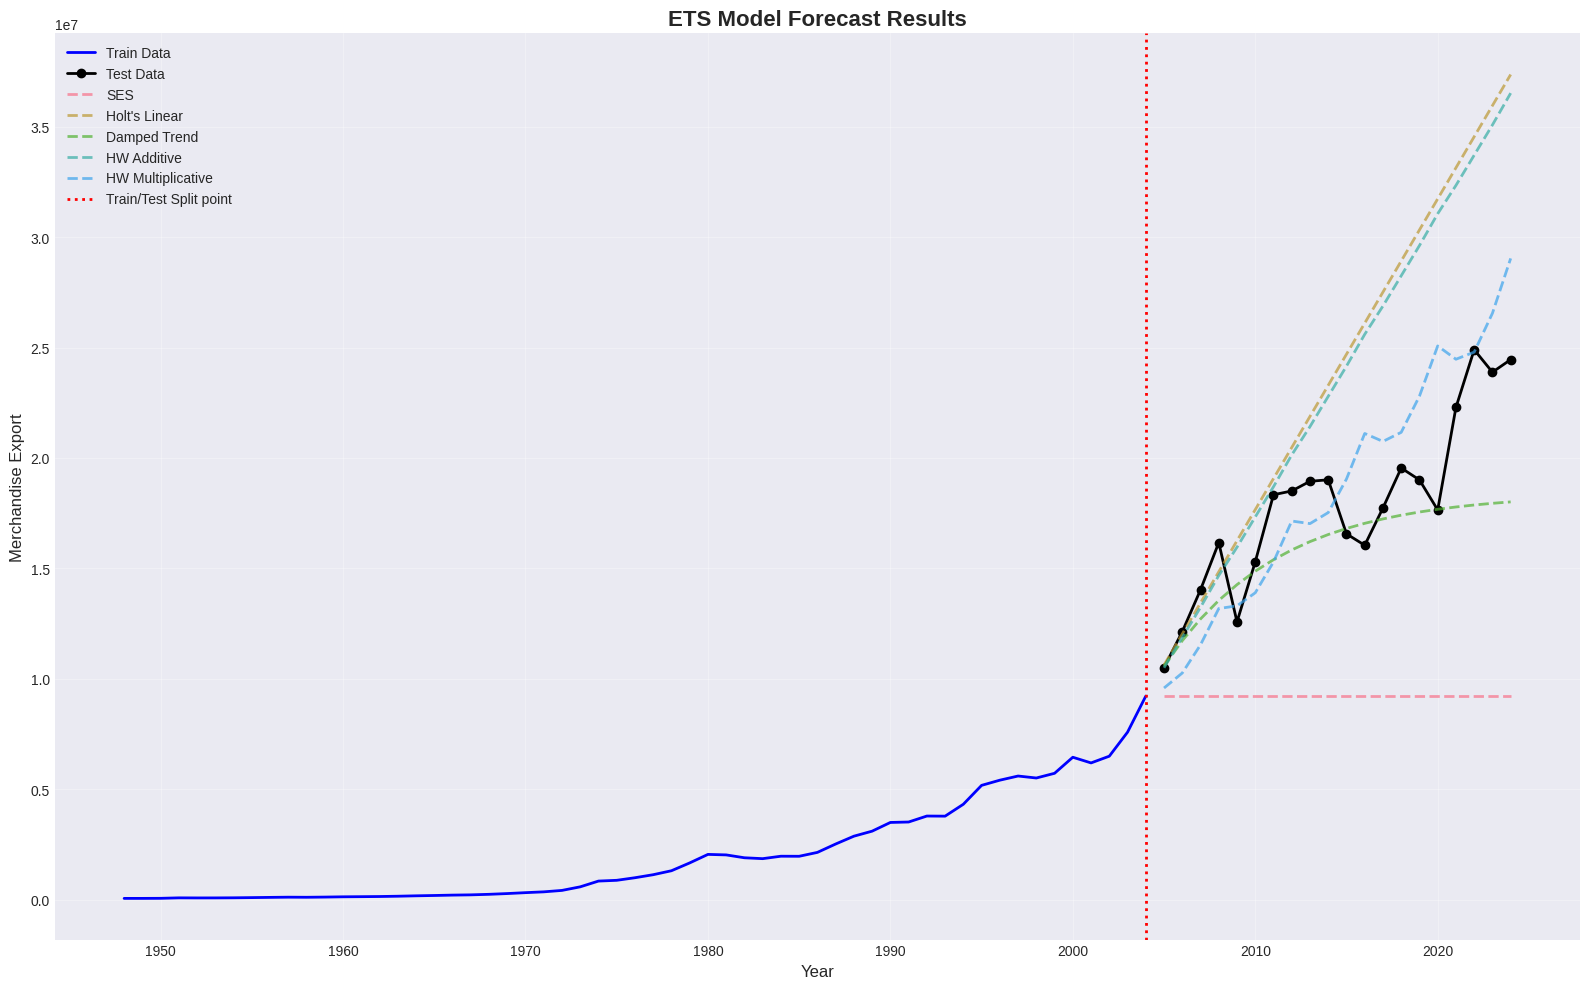

In [41]:
## 7. 예측 결과 시각화

plt.figure(figsize=(16, 10))

# 모든 모델의 예측 결과를 하나의 그래프에 표시
plt.plot(train_data.index, train_data.values, label='Train Data', linewidth=2, color='blue')
plt.plot(test_data.index, test_data.values, label='Test Data', linewidth=2, color='black', marker='o')
plt.plot(test_data.index, forecast_ses, label='SES', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(test_data.index, forecast_holt, label="Holt's Linear", linewidth=2, linestyle='--', alpha=0.7)
plt.plot(test_data.index, forecast_damped, label='Damped Trend', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(test_data.index, forecast_hw_add, label='HW Additive', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(test_data.index, forecast_hw_mul, label='HW Multiplicative', linewidth=2, linestyle='--', alpha=0.7)

plt.axvline(x=train_data.index[-1], color='red', linestyle=':', linewidth=2, label='Train/Test Split point')
plt.title('ETS Model Forecast Results', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Merchandise Export', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. 최적 모델 분석

In [42]:
# 성능이 가장 좋은 모델 선택 (RMSE 기준)
best_model_idx = results_df['RMSE'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"최적 모델: {best_model_name}")

최적 모델: HW Multiplicative


In [43]:
final_fit = fit_hw_mul

In [44]:
print(final_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    World   No. Observations:                   57
Model:             ExponentialSmoothing   SSE                  2359959524254.726
Optimized:                         True   AIC                           1409.457
Trend:                         Additive   BIC                           1425.801
Seasonal:                Multiplicative   AICC                          1414.240
Seasonal Periods:                     4   Date:                 Sat, 11 Oct 2025
Box-Cox:                          False   Time:                         01:44:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

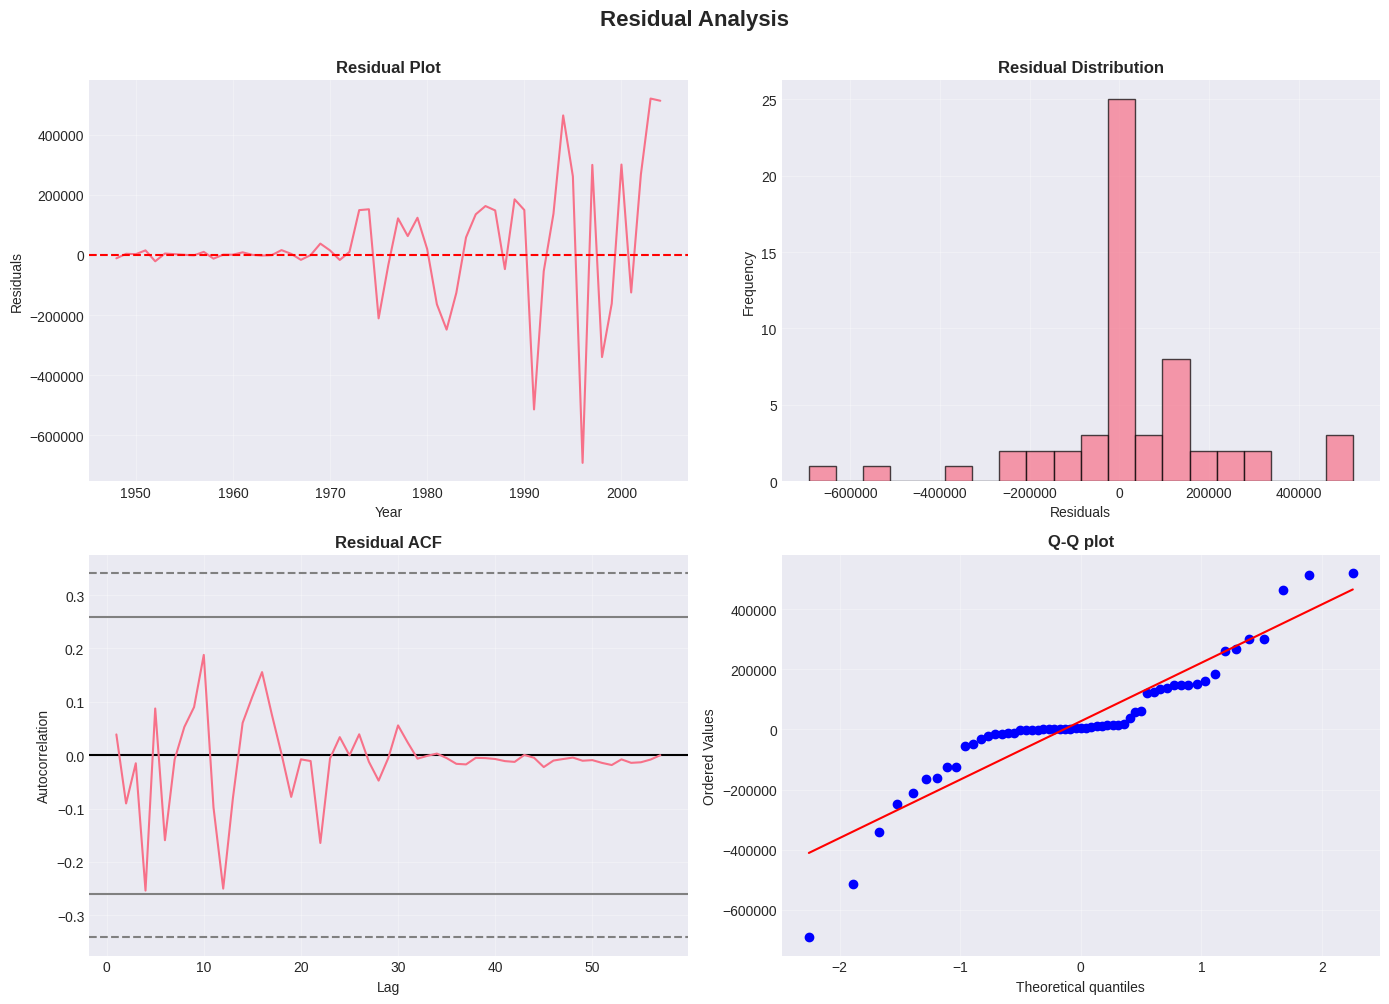

In [45]:
# 잔차 분석
residuals = ts_data - final_fit.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 잔차 시계열 플롯
axes[0, 0].plot(residuals.index, residuals.values)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residual Plot', fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# 잔차 히스토그램
axes[0, 1].hist(residuals.dropna(), bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residual Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Simple ACF
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(residuals.dropna(), ax=axes[1, 0])
axes[1, 0].set_title('Residual ACF', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q 플롯
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

위와 같이 구현해도 되지만 보다 더 포괄적인 프레임워크를 위해서는 `statsmodels`의 `ETSModel`을 로드하여 사용해도 됩니다.

참고: https://www.statsmodels.org/dev/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html

사용 예시
```python
# ETS(A,A,A) - Additive Error, Additive Trend, Additive Seasonal
print("\n=== ETS(A,A,A) ===")
model_aaa = ETSModel(train_data, error='add', trend='add', seasonal='add', seasonal_periods=12)
fit_aaa = model_aaa.fit()
forecast_aaa = fit_aaa.forecast(steps=12)


# ETS(M,A,M) - Multiplicative Error, Additive Trend, Multiplicative Seasonal
print("\n=== ETS(M,A,M) ===")
model_mam = ETSModel(train_data, error='mul', trend='add', seasonal='mul', seasonal_periods=12)
fit_mam = model_mam.fit()
forecast_mam = fit_mam.forecast(steps=12)


# ETS(M,Ad,M) - Multiplicative Error, Additive Damped Trend, Multiplicative Seasonal
print("\n=== ETS(M,Ad,M) ===")
model_madm = ETSModel(train_data, error='mul', trend='add', seasonal='mul', seasonal_periods=12, damped_trend=True)
fit_madm = model_madm.fit()
forecast_madm = fit_madm.forecast(steps=12)
```